


# Home load approval prediction
## 1. Problem Defintion
This project provides homeload approval predictions based on features such as ...... using the RandomForestClassifier
## 2. Data
- Train: https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_test.csv
- Test: https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_test.csv
## 3. Evaluation
## 4. Features


In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix




# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC


import ipywidgets as widgets
from IPython.display import display
import joblib



# we want our plots to appear inside the notebook
%matplotlib inline


In [2]:
train_url = "https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_train.csv"
test_url = "https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_test.csv"

df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

print("-- Train ----------- ")

print(df.head().T)
print(" ")
print("-- Test ----------- ")
print(test_df.head().T)

-- Train ----------- 
                          0         1         2             3         4
Loan_ID            LP001002  LP001003  LP001005      LP001006  LP001008
Gender                 Male      Male      Male          Male      Male
Married                  No       Yes       Yes           Yes        No
Dependents                0         1         0             0         0
Education          Graduate  Graduate  Graduate  Not Graduate  Graduate
Self_Employed            No        No       Yes            No        No
ApplicantIncome        5849      4583      3000          2583      6000
CoapplicantIncome       0.0    1508.0       0.0        2358.0       0.0
LoanAmount              NaN     128.0      66.0         120.0     141.0
Loan_Amount_Term      360.0     360.0     360.0         360.0     360.0
Credit_History          1.0       1.0       1.0           1.0       1.0
Property_Area         Urban     Rural     Urban         Urban     Urban
Loan_Status               Y         N     

# Exploratory Data Analysis

In [3]:


df.head().T


,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [6]:
# # Plot histogram for each feature
# df['LoanAmount'].hist(bins=30)
# plt.title('LoanAmount Distribution')
# plt.xlabel('LoanAmount')
# plt.ylabel('Frequency')
# plt.show()

In [7]:
def preprocess_data(df, training=True):


    # Drop Loan_ID column if present
    if 'Loan_ID' in df.columns:
        df = df.drop(columns=['Loan_ID'])

    # Handle missing values
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Numeric columns
            df[col] = df[col].fillna(df[col].median())
        elif df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].fillna(df[col].mode()[0])


    # Convert "3+" in Dependents to 3 and make column numeric
    if 'Dependents' in df.columns:
        df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

    # Encode categorical variables
    # Turning value into number codes
    categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed']
    for col in categorical_columns:
        if col in df.columns:
            df[col] = pd.Categorical(df[col]).codes  # Convert categories to numeric codes

    #One-hot encode 'Property_Area' (if needed)
    # One hot encoding splits properta area values into their own columns so they can have binary values
    if 'Property_Area_Semiurban' in df.columns and 'Property_Area_Urban' in df.columns:
        pass
    else:
        if 'Property_Area' in df.columns:
            df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)

    # 7. Convert target column 'Loan_Status' to binary (if training)
    if training and 'Loan_Status' in df.columns:
        df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

    # 8. Remove target column for test data (if not training)
    if not training and 'Loan_Status' in df.columns:
        df = df.drop(columns=['Loan_Status'])

    return df

In [8]:
# INSPECT MISSING VALUES

df_train = preprocess_data(df)
print(df_train.isna().sum())


Gender                     0
Married                    0
Dependents                 0
Education                  0
Self_Employed              0
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Credit_History             0
Loan_Status                0
Property_Area_Semiurban    0
Property_Area_Urban        0
dtype: int64


In [9]:
print(df_train.head().T)


                             0       1      2       3      4
Gender                       1       1      1       1      1
Married                      0       1      1       1      0
Dependents                   0       1      0       0      0
Education                    0       0      0       1      0
Self_Employed                0       0      1       0      0
ApplicantIncome           5849    4583   3000    2583   6000
CoapplicantIncome          0.0  1508.0    0.0  2358.0    0.0
LoanAmount               128.0   128.0   66.0   120.0  141.0
Loan_Amount_Term         360.0   360.0  360.0   360.0  360.0
Credit_History             1.0     1.0    1.0     1.0    1.0
Loan_Status                  1       0      1       1      1
Property_Area_Semiurban  False   False  False   False  False
Property_Area_Urban       True   False   True    True   True


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   614 non-null    int8   
 1   Married                  614 non-null    int8   
 2   Dependents               614 non-null    int32  
 3   Education                614 non-null    int8   
 4   Self_Employed            614 non-null    int8   
 5   ApplicantIncome          614 non-null    int64  
 6   CoapplicantIncome        614 non-null    float64
 7   LoanAmount               614 non-null    float64
 8   Loan_Amount_Term         614 non-null    float64
 9   Credit_History           614 non-null    float64
 10  Loan_Status              614 non-null    int64  
 11  Property_Area_Semiurban  614 non-null    bool   
 12  Property_Area_Urban      614 non-null    bool   
dtypes: bool(2), float64(4), int32(1), int64(2), int8(4)
memory usage: 34.9 KB


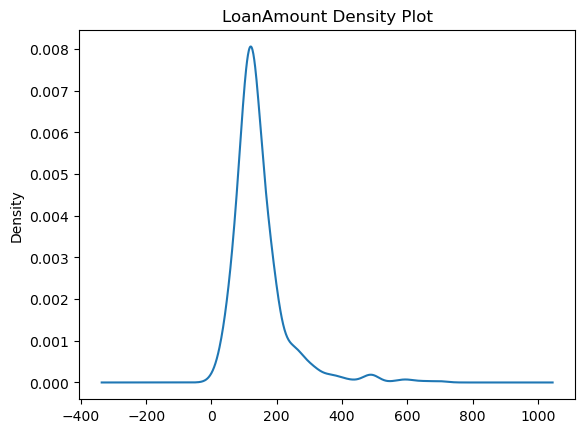

In [11]:
df_train['LoanAmount'].plot(kind='kde')
plt.title('LoanAmount Density Plot')
plt.show()
# NORMAL DISTRIBUTION USE STANDARD SCALAR

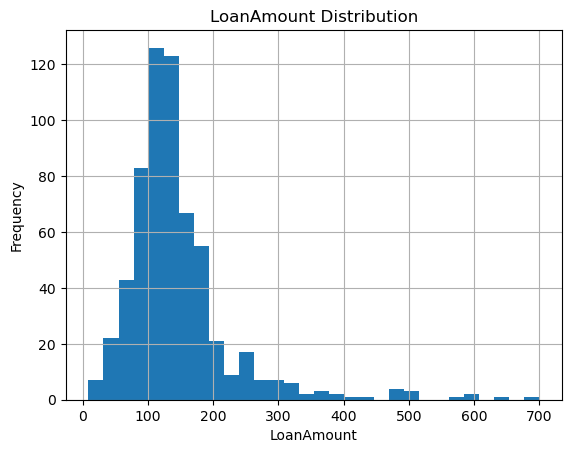

In [12]:
# Plot histogram for each feature
df_train['LoanAmount'].hist(bins=30)
plt.title('LoanAmount Distribution')
plt.xlabel('LoanAmount')
plt.ylabel('Frequency')
plt.show()

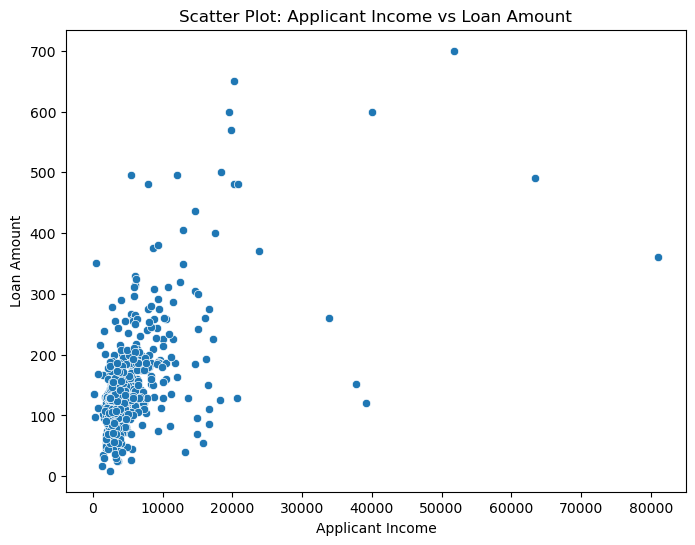

Correlation between Applicant Income and Loan Amount: 0.57


In [13]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_train['ApplicantIncome'], y=df_train['LoanAmount'])
plt.title('Scatter Plot: Applicant Income vs Loan Amount')
plt.xlabel('Applicant Income')
plt.ylabel('Loan Amount')
plt.show()

# Calculate correlation coefficient
correlation = df_train['ApplicantIncome'].corr(df_train['LoanAmount'])
print(f"Correlation between Applicant Income and Loan Amount: {correlation:.2f}")

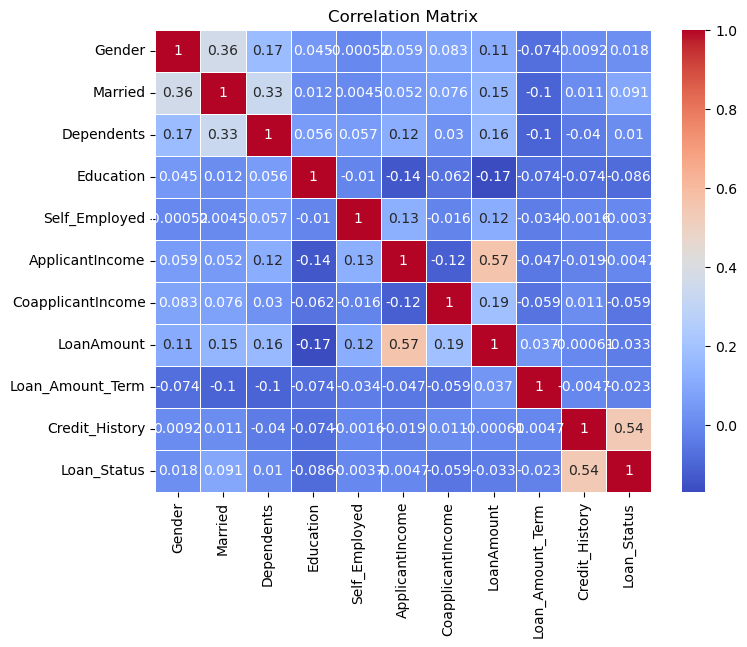

In [14]:
# Create a copy of the DataFrame
df_copy = df_train.copy()


# Select only numeric columns
numeric_df = df_copy.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [15]:
X = df_train.drop(columns=['Loan_Status'])
y = df_train['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X_train.columns.tolist()



In [16]:
print(X.shape, X_train.shape, X_val.shape)

(614, 12) (491, 12) (123, 12)


In [17]:
# Baseline: Predict the majority class
baseline_prediction = y_train.mode()[0]  # Most frequent target
baseline_accuracy = (y_train == baseline_prediction).mean()
print(f'Baseline Accuracy: {baseline_accuracy}')

Baseline Accuracy: 0.6965376782077393


In [18]:
# # Scale the training and validation features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "LinearSVC": LinearSVC(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled if name != "Random Forest" else X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_scaled if name != "Random Forest" else X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f'{name} Accuracy: {accuracy:.4f}')

Logistic Regression Accuracy: 0.7886
LinearSVC Accuracy: 0.7886
Random Forest Accuracy: 0.7805


In [19]:
# import numpy as np

# # Check for infinite values in scaled data
# print(np.isinf(X_train_scaled).sum())  # Should output 0
# print(np.isnan(X_train_scaled).sum())  # Should output 0

# # Check basic statistics
# print("Scaled data description:\n", pd.DataFrame(X_train_scaled).describe())


In [30]:

# Tune Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_scaled, y_train)

# Tune LinearSVC
param_grid_svc = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_svc = GridSearchCV(LinearSVC(random_state=42, max_iter=1000), param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train_scaled, y_train)

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Replace 'auto' with valid options
}
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available processors
)
grid_search_rf.fit(X_train, y_train)

# Compare Results
print(f"Best Logistic Regression Parameters: {grid_search_lr.best_params_}")
print(f"Best Logistic Regression Accuracy: {grid_search_lr.best_score_:.4f}")
print(f"Best LinearSVC Parameters: {grid_search_svc.best_params_}")
print(f"Best LinearSVC Accuracy: {grid_search_svc.best_score_:.4f}")
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
print(f"Best Random Forest Accuracy: {grid_search_rf.best_score_:.4f}")


Best Logistic Regression Parameters: {'C': 0.1}
Best Logistic Regression Accuracy: 0.8166
Best LinearSVC Parameters: {'C': 0.01}
Best LinearSVC Accuracy: 0.8166
Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best Random Forest Accuracy: 0.8125


In [21]:
# Evaluate the best Random Forest model
best_rf = grid_search_rf.best_estimator_
y_val_pred = best_rf.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.7886
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Confusion Matrix:
[[18 25]
 [ 1 79]]


In [22]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    # Create a DataFrame for features and their importances
    df = (pd.DataFrame({
        "features": columns,
        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the top n features
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(df["features"][:n], df["feature_importances"][:n], color='skyblue')
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.set_title("Top Feature Importances")
    ax.invert_yaxis()  # Reverse the order to show the highest importance on top
    plt.tight_layout()
    plt.show()

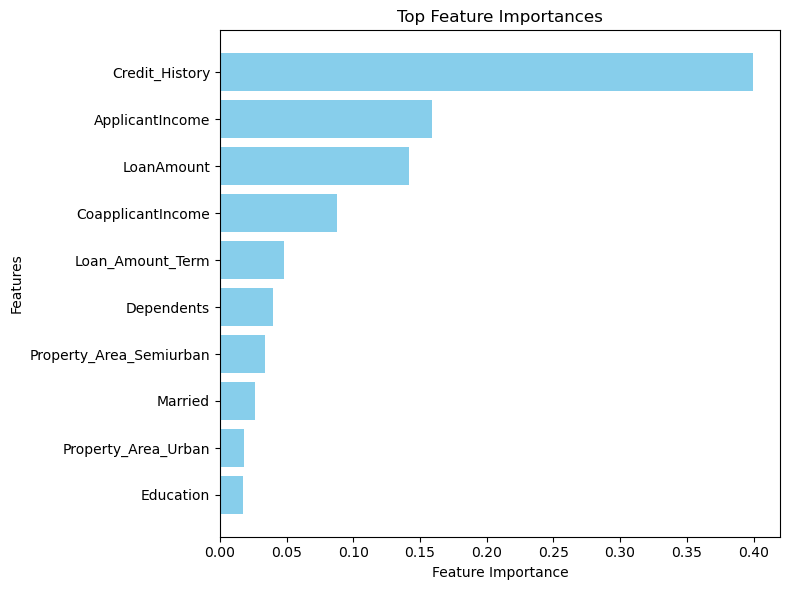

In [23]:
columns = X_train.columns
importances = best_rf.feature_importances_

# Plot the top 10 features
plot_features(columns, importances, n=10)

In [24]:
def recommend_actions(row, model):
    # Convert the row into a 2D DataFrame for prediction
    row_df = row.to_frame().T  # Converts Series to DataFrame and transposes it
    
    # Predict using the model
    prediction = model.predict(row_df)[0]    
    if prediction == 1:  # Loan Approved
        return "Loan approved"
    else:  # Loan Denied
        if row['Credit_History'] == 0:
            return "Improve credit history to increase approval chances."
        elif row['LoanAmount'] > row['ApplicantIncome'] * 0.5:
            return "Consider applying for a lower loan amount."
        else:
            return "Consult the bank for more details."


In [25]:
# Preprocess the test dataset
X_test = preprocess_data(test_df, training=False)


# Ensure columns are in the same order as the training set
X_test = X_test[feature_names]

# Predict using the best Random Forest model
test_predictions = best_rf.predict(X_test)

# Convert predictions to required format ('Y'/'N')
test_predictions = ['Y' if pred == 1 else 'N' for pred in test_predictions]

# Create a DataFrame for submission
submission = pd.DataFrame({
    'Loan_ID': test_df['Loan_ID'],  # Assuming test.csv includes Loan_ID
    'Loan_Status': test_predictions
})

# Save the submission to a CSV file
# submission.to_csv('submission.csv', index=False)
# print("Predictions saved to submission.csv")
# print(submission.head())

# recommendations = X_test.apply(lambda row: recommend_actions(row, best_rf), axis=1)
# X_test['Recommendations'] = recommendations
# X_test.to_csv('recc.csv', index=False)

In [26]:
# joblib.dump(best_rf, 'random_forest_model.pkl')
# print("Model exported as random_forest_model.pkl")

In [27]:
# rf_model = joblib.load('random_forest_model.pkl')  # Load your trained model
rf_model = best_rf

# Define the input form fields
gender_dropdown = widgets.Dropdown(
    options=['Male', 'Female'],
    value='Male',
    description='Gender:',
)

married_dropdown = widgets.Dropdown(
    options=['No', 'Yes'],
    value='No',
    description='Married:',
)

dependents_dropdown = widgets.Dropdown(
    options=[0, 1, 2, '3+'],
    value=0,
    description='Dependents:',
)

education_dropdown = widgets.Dropdown(
    options=['Graduate', 'Not Graduate'],
    value='Graduate',
    description='Education:',
)

self_employed_dropdown = widgets.Dropdown(
    options=['No', 'Yes'],
    value='No',
    description='Self-Employed:',
)

applicant_income = widgets.IntText(
    value=5000,
    description='ApplicantIncome:',
)

coapplicant_income = widgets.IntText(
    value=0,
    description='CoapplicantIncome:',
)

loan_amount = widgets.IntText(
    value=150,
    description='LoanAmount:',
)

loan_term = widgets.IntSlider(
    value=360,
    min=12,
    max=480,
    step=12,
    description='Loan Term:',
)

credit_history = widgets.Dropdown(
    options=[1.0, 0.0],
    value=1.0,
    description='Credit History:',
)

property_area = widgets.Dropdown(
    options=['Urban', 'Semiurban', 'Rural'],
    value='Urban',
    description='Property Area:',
)

# Function to process inputs and make a prediction
def make_prediction(*args):
    print("Button clicked!") 
   # Collect inputs into a single row
    input_data = pd.DataFrame([{
        'Gender': 1 if gender_dropdown.value == 'Male' else 0,
        'Married': 1 if married_dropdown.value == 'Yes' else 0,
        'Dependents': 3 if dependents_dropdown.value == '3+' else int(dependents_dropdown.value),
        'Education': 1 if education_dropdown.value == 'Graduate' else 0,
        'Self_Employed': 1 if self_employed_dropdown.value == 'Yes' else 0,
        'ApplicantIncome': applicant_income.value,
        'CoapplicantIncome': coapplicant_income.value,
        'LoanAmount': loan_amount.value,
        'Loan_Amount_Term': loan_term.value,
        'Credit_History': credit_history.value,
        'Property_Area_Urban': 1 if property_area.value == 'Urban' else 0,
        'Property_Area_Semiurban': 1 if property_area.value == 'Semiurban' else 0
    }])

    # Align columns with training data
    input_data = input_data[X_train.columns]  # Reorder columns to match X_train

    # Make a prediction
    prediction = rf_model.predict(input_data)[0]
    result = "Approved" if prediction == 1 else "Denied"
    print(f"Loan Prediction: {result}")

# Create a button to trigger prediction
predict_button = widgets.Button(description="Predict")
predict_button.on_click(make_prediction)

# Display the form and button
display(gender_dropdown, married_dropdown, dependents_dropdown, education_dropdown, self_employed_dropdown,
        applicant_income, coapplicant_income, loan_amount, loan_term, credit_history, property_area, predict_button)


Dropdown(description='Gender:', options=('Male', 'Female'), value='Male')

Dropdown(description='Married:', options=('No', 'Yes'), value='No')

Dropdown(description='Dependents:', options=(0, 1, 2, '3+'), value=0)

Dropdown(description='Education:', options=('Graduate', 'Not Graduate'), value='Graduate')

Dropdown(description='Self-Employed:', options=('No', 'Yes'), value='No')

IntText(value=5000, description='ApplicantIncome:')

IntText(value=0, description='CoapplicantIncome:')

IntText(value=150, description='LoanAmount:')

IntSlider(value=360, description='Loan Term:', max=480, min=12, step=12)

Dropdown(description='Credit History:', options=(1.0, 0.0), value=1.0)

Dropdown(description='Property Area:', options=('Urban', 'Semiurban', 'Rural'), value='Urban')

Button(description='Predict', style=ButtonStyle())